# Mie Theory Task : 4

Name: Jayendra Praveen Kumar Chorapalli  
Matriculation Number: 03736602



Importing necessary libraries

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.special import lpmv as leg
import time
import pylab

#### Function definition to Compute the associated Legendre functions by recurrence.


In [3]:
def legqkm(m, ncoef, mu0, mu):
    """Compute the associated Legendre functions by recurrence.

    Receive:

        m : int
            order of associated Legendre functions
        ncoef : int
            maximum degree of the associated Legendre functions; legpkm
            will compute from P_{m,m}(mu) until P_{ncoef,m}(mu)
        mu0 : float
            input value where the associated Legendre functions are
            evaluated (income direction)
        mu : array-like, shape (nmu,)
            input values where the associated Legendre functions are
            evaluated (outcome directions)
    """

    # Check that 'm' and 'ncoef' are within the valid range.
    if m < 0:
        raise ValueError("'m' must be a non-negative integer")
    if ncoef < 1:
        raise ValueError("'ncoef' must be a positive integer")

    # Declare local variables.
    nmu = np.size(mu)
    nm = ncoef - m

    # Allocate output variables p0 and pkm.
    pkm0 = np.zeros((ncoef,))
    pkm = np.zeros((ncoef, nmu))

    if nm > 0:

        # Evaluate Pmm and store them on the first column.
        if m > 0:
            sim0 = 1.
            for j in range(1, m + 1):
                sim0 *= (1. - 0.5 / j)**0.5
            pkm0[0] = sim0 * ((1. - mu0**2)**m)**0.5
            for j in range(nmu):
                pkm[0, j] = sim0 * ((1. - mu[j]**2)**m)**0.5
        else:
            pkm0[0] = 1.
            for j in range(nmu):
                pkm[0, j] = 1.

        if nm > 1:

            # Evaluate P_{m+1,m} and store them on the second column.
            sim1 = (2 * m + 1)**0.5
            pkm0[1] = sim1 * mu0 * pkm0[0]
            for j in range(nmu):
                pkm[1, j] = sim1 * mu[j] * pkm[0, j]

            # Evaluate P_{lm} (l > m + 1) and store them on the other columns.
            for i in range(0, nm - 2):

                k = i + m + 2
                invsqkm = 1. / (k**2 - m**2)**0.5
                c1 = (2 * k - 1) * invsqkm
                c2 = ((k - 1)**2 - m**2)**0.5 * invsqkm

                pkm0[i + 2] = c1 * mu0 * pkm0[i + 1] - c2 * pkm0[i]
                for j in range(0, nmu):
                    pkm[i + 2, j] = c1 * mu[j] * pkm[i + 1, j] - c2 * pkm[i, j]

    return pkm0, pkm.T



#### Function definitions to calculate DOM and SSA for the given input values

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 17 17:38:47 2022

"""


import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.special import lpmv as leg
# from legqkm import legqkm
import time
import pylab


def put_in_global_matrix(WA,sh, Ndo, Ep_, V_inv,iLayer):
    N2 = Ndo
    N1 = 2*Ndo
    # adding A
    WA[sh+N2+N1*iLayer:sh+N2+N1*iLayer+N2 ,sh+N1*iLayer:sh+N1*iLayer+N2] = -V_inv[0:N2,0:N2]
    WA[sh+N2+N1*iLayer:sh+N2+N1*iLayer+N2 ,sh+N1*iLayer+N2:sh+N1*iLayer+N2+N2] = -V_inv[0:N2,N2:N1]
    WA[sh+N2+N2+N1*iLayer:sh+N2+N2+N1*iLayer+N2,sh+N1*iLayer:sh+N1*iLayer+N2] = -V_inv[N2:N1,0:N2]*Ep_[:,None]
    WA[sh+N2+N2+N1*iLayer:sh+N2+N2+N1*iLayer+N2,sh+N1*iLayer+N2:sh+N1*iLayer+N2+N2] =  -V_inv[N2:N1,N2:N1]*Ep_[:,None]
    # adding B
    WA[sh+N2+N1*iLayer:sh+N2+N1*iLayer+N2,sh+N1*(iLayer+1):sh+N1*(iLayer+1)+N2] =  V_inv[0:N2,0:N2]*Ep_[:,None]
    WA[sh+N2+N1*iLayer:sh+N2+N1*iLayer+N2,sh+N1*(iLayer+1)+N2:sh+N1*(iLayer+1)+N2+N2] = V_inv[0:N2,N2:N1]*Ep_[:,None]
    WA[sh+N2+N1*iLayer+N2:sh+N2+N1*iLayer+N2+N2,sh+N1*(iLayer+1):sh+N1*(iLayer+1)+N2] =V_inv[N2:N1,0:N2]
    WA[sh+N2+N1*iLayer+N2:sh+N2+N1*iLayer+N2+N2,sh+N1*(iLayer+1)+N2:sh+N1*(iLayer+1)+N2+N2] = V_inv[N2:N1,N2:N1]
    

def eigenvalue_problem(m, Ndo, p,V0, mu_p, w):
    # phase functions can be computed as
    # p = sum over k=0,Nk_tr-m: (2(k+m)+1)*xp[k+m]*Qkm[k,mu1]*Qkm[k,mu2]
    # p_m.shape = (2*Ndo 2*Ndo)
   
    ''' computing a layer matrix A '''
    # A = [[A11 A12][-A12 -A11]]
    # in Budak's paper A11 = alef, A12 = bet
    ''' matrix exponential (eigenvalue problem)'''
    A11 = 0.5*p[0:Ndo, 0:Ndo]*w[:]*V0/mu_p[:,None] - np.diag(1.0/mu_p[0:Ndo]);
    A12 = 0.5*p[0:Ndo, Ndo:2*Ndo]*w[:]*V0/mu_p[:,None];
    # smart stuff with Waterman's scaling :)  Efremenko et al. Acceleration techniques...// JQSRT 2012        
    T_scaled = np.sqrt(2*mu_p*w)
    T_scaled_inv = 1.0/T_scaled
    A11 = A11*T_scaled[:,None]*T_scaled_inv
    A12 = A12*T_scaled[:,None]*T_scaled_inv
    A11pA12 = A11+A12
    A_p = (A11-A12).dot(A11pA12)
    [e_val, e_vec_p] = np.linalg.eig(A_p)
    #[e_val, e_vec_p] = scipy.linalg.eig(A_p)
    e_val = np.real(e_val)
    e_vec_p = np.real(e_vec_p)

    Lambda = np.sqrt(e_val)
                
    # reordering
    order = Lambda.argsort()
    Lambda = Lambda[order[::-1]]
    e_vec_p = e_vec_p.T[order[::-1]].T
     
    e_vec_m = (A11pA12.dot(e_vec_p))/Lambda
                
    V_p = 0.5*(e_vec_p + e_vec_m)
    V_m = 0.5*(e_vec_p - e_vec_m)
    norm = np.sqrt(np.abs(np.sum(V_p*V_p-V_m*V_m,axis=0)))
    V_p = V_p/norm
    V_m = V_m/norm
        
    V_inv = np.concatenate([np.concatenate([V_m.T*T_scaled, -V_p.T*T_scaled], axis=1), np.concatenate([-V_p.T*T_scaled, V_m.T*T_scaled], axis=1)]);
    V = np.concatenate([np.concatenate([V_m*T_scaled_inv[:,None], V_p*T_scaled_inv[:,None]], axis=1), np.concatenate([V_p*T_scaled_inv[:,None], V_m*T_scaled_inv[:,None]], axis=1)]);
    #V_inv = np.concatenate([np.concatenate([V_m.T*T_scaled, -V_p.T*T_scaled], axis=1), np.concatenate([V_p.T*T_scaled, -V_m.T*T_scaled], axis=1)]);
    #V = np.concatenate([np.concatenate([V_m*T_scaled_inv[:,None], V_p*T_scaled_inv[:,None]], axis=1), np.concatenate([V_p*T_scaled_inv[:,None], V_m*T_scaled_inv[:,None]], axis=1)]);
    # V.dot(V_inv) = E  % you can check it :)    
    return [V,V_inv,Lambda];


#####################################################
#                   SJ function                     #
#####################################################
# Essentially this is the part of the source function that 
# depends on the parameters of the current layers
def SJ_function(mu0,mu, Q0, Qkm, dX, Lambda, V_inv, p0, V0):
    Ep_ = np.exp(-Lambda*dX);
    #TempN1 = np.concatenate([(Ep_*np.exp(-dX/mu0)-1.0)/(-Lambda-1.0/mu0), (np.exp(-dX/mu0)-Ep_)/(Lambda-1.0/mu0)], axis=1);
    TempN1 = np.concatenate([(Ep_*np.exp(-dX/mu0)-1.0)/(-Lambda-1.0/mu0), (np.exp(-dX/mu0)-Ep_)/(Lambda-1.0/mu0)], axis=0);
    TempN1N1 = V_inv*TempN1[:,None];
    return TempN1N1.dot(p0/mu[:])*V0/(4*np.pi);

def single_layer_DOM(mu0, phi, Ndo, tau_true, ssa_true, xn_true, Ro, mu_false = []):
    #input
    N_false = len(mu_false)
    Nlayers = 1
    
    tau_levels = 0
    #Ndo = 64
    Nn_tr = 2*(Ndo+N_false)
    # scaling
    f0 = xn_true[Nn_tr]
    f1 = 1.0 - f0
    f2 = 1.0 - ssa_true*f0
    ssa = ssa_true*f1/f2
    tau = tau_true*f2
    xn =  (xn_true[0:Nn_tr]-f0)/f1

    n = np.arange(0,Nn_tr)
    n2xn = (2*n+1)*xn
    
    # double quadrature
    [mu_temp, w2] = np.polynomial.legendre.leggauss(Ndo)
    mu_m = 0.5*(mu_temp[0:Ndo]-1)
    mu_p = -mu_m[0:Ndo]
    
    if N_false>0:
        mu_m = np.concatenate ( (mu_m[0:Ndo], -np.array(mu_false) )  )
        Ndo = Ndo + N_false
        mu_p = -mu_m[0:Ndo]
        w2 = np.concatenate ( (w2, 0.000001+np.zeros(N_false) )  )

    mu = np.concatenate([mu_m,mu_p])
    w = w2/2
    
    # azimuthal loop
    m = -1
    Mmax = 2*Ndo
    #Mmax = 0
    #print('M is fixed to 0')
    convergence = False
    
    eig_time_total = 0
    lin_time_total = 0
    
    while (m<Mmax) and (not convergence):
        #print(m)
        m += 1
        size = (Nlayers+1)*2*Ndo # 2Ndo for each lazer plus 2Ndo for boundary conditions
        U = np.zeros(size*size).reshape(size,size)
        Q_source = np.zeros(size)
        
        start_time = time.time()

        P_mu0, P_nm_mu = legqkm(m, Nn_tr, mu0, mu)
        P_nm_mu = P_nm_mu[0:Nn_tr].T
        
        # construction of the layer matrix A = [[A11 A12][-A12 -A11]]
        p_m = (P_nm_mu[:,:]*np.concatenate([n2xn[m:Nn_tr],np.zeros(m)])[:,None]).T.dot(P_nm_mu[:,:])
        [eigenvectors,eigenvectors_inv,eigenvalues] = eigenvalue_problem(m, Ndo, p_m,ssa, mu_p, w)
        Gamma = np.exp(-eigenvalues*tau)
        
        # source function
        p0 = (P_nm_mu*np.concatenate([n2xn[m:Nn_tr],np.zeros(m)])[:,None]).T.dot(P_mu0) # phase function
        TempN1 = np.concatenate([(Gamma*np.exp(-tau/mu0)-1.0)/(-eigenvalues-1.0/mu0), (np.exp(-tau/mu0)-Gamma)/(eigenvalues-1.0/mu0)], axis=0)
        TempN1N1 = eigenvectors_inv*TempN1[:,None]
        
        time_temp = time.time()
        eig_time = time_temp - start_time
        eig_time_total += eig_time
        source = (2 - (m == 0)) * TempN1N1.dot(p0/mu[:])*ssa/(4*np.pi)
        Q_source[Ndo: Ndo+2*Ndo] = np.exp(-tau_levels/mu0) *source # put in the global system
        
        # global matrix
        sh = 0
        iLayer = 0
        put_in_global_matrix(U,sh, Ndo, Gamma, eigenvectors_inv,iLayer)
        
        # upper boundary
        for i in range(0,Ndo):
            U[i,Ndo+i] = 1.0
        
        # lower boundary
        for i in range(0,Ndo):
            U[size-Ndo+i,size-2*Ndo+i] =1.0
            
        #  with Lambert reflection:
        if(m==0):
            U[size-Ndo:size,size-Ndo:size] = -Ro*w2*mu_p
            Q_source[size-Ndo:size] = Ro/np.pi*mu0*np.exp(-tau/mu0)
        else:
            U[size-Ndo:size,size-Ndo:size] = 0.0
            Q_source[size-Ndo:size] = 0.0
        
        L_m = np.linalg.solve(U, Q_source)
        lin_time = time.time() - time_temp
        lin_time_total += lin_time
        if m == 0:
            L = L_m
        else:
            L += L_m*np.cos(m*phi)
            if np.max((np.absolute(L_m[3*Ndo:4*Ndo]))/np.absolute(L[3*Ndo:4*Ndo])) < 0.001:
                convergence = True
                print("Convergence at M =", m)

    #L_reflected = L[0:Ndo]
    #L_transmitted = L[3*Ndo:4*Ndo]
    #print ("eig ",eig_time_total)
    #print ("lin ", lin_time_total)
    return [mu_p, L]


    
def stupid_eig():
    p = (P_nm_mu[:,:]*np.concatenate([n2xn[m:Nn_tr],np.zeros(m)])[:,None]).T.dot(P_nm_mu[:,:])
    A11 = np.diag(1.0/mu_p[0:Ndo]) - 0.5*p[0:Ndo, 0:Ndo]*w[:]*ssa/mu_p[:,None]
    A12 = -0.5*p[0:Ndo, Ndo:2*Ndo]*w[:]*ssa/mu_p[:,None]
    A = np.concatenate( (np.concatenate( (A11, A12), axis=1), np.concatenate( (-A12, -A11), axis=1)))
        
    [eigenvalues, eigenvectors] = scipy.linalg.eig(A)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real

    eigenvectors_inv = np.linalg.inv(eigenvectors) 
    order = eigenvalues.argsort()
    eigenvalues = eigenvalues[order[::-1]][0:Ndo]
        
    eigenvectors_inv = eigenvectors_inv[:,order[::-1]][0:Ndo].T
    
    
    
def phase_func_via_associated_leg(mu1, mu2, phi,pl, Mmax = 50):
    """Compute phase function given angles defined in the coordinate system

    Recieve:
        mu1: float
            cosine of the incident zenith angle
        mu2: float
            cosine of the escaping zenith angle
        phi: float
            relative azimuth angle
        Mmax: float (by default 50 to save the computational time - sometimes should be increased)
            maximum number of azimuthal harmonics
    Return:
        p : float
            phase function value
    """
    Lmax = len(pl)
    Mmax = min(Mmax,Lmax-1)
    # we define array 1,2,2,2,2,2,2,2,...
    one_two = 2*np.ones(Mmax)
    one_two[0] = 1
    Nk = len(pl)
    K2xk_temp = (2*np.arange(0,Nk)+1)*pl
    Nmu = 1
    # Q0 is the associated Legendre polynomial Pnm(mu1)*np.sqrt((n-m)!/(n+m)!)
    Q0 = np.zeros(Nk+1)
    # Qkm is the associated Legendre polynomial Pnm(mu2)*np.sqrt((n-m)!/(n+m)!)
    Qkm = np.zeros(Nmu*Nk).reshape(Nmu,Nk)
    p = 0
    for m in range(Mmax):
        xkk = np.concatenate([K2xk_temp[m:Nk],np.zeros(m)])
        Q0, Qkm = legqkm(m, Lmax, mu1, np.array([mu2]))
        Q0 = Q0[0:Nk]
        p = p + (Qkm.T*xkk[:,None]).T.dot(Q0[0:Nk])*np.cos(m*phi)*one_two[m]
    return p

def single_scat_approx(TAU,mu0,mu,x1,phi):
    p=phase_func_via_associated_leg(mu0, mu, phi,xl)
    if mu>0:
        if mu==mu0:
            l=(0.999/(4*np.pi))*p*np.exp(-TAU/mu)*(TAU/mu)
        else:
            l=(0.999/(4*np.pi))*p*(mu0/(mu-mu0))*(np.exp(-TAU/mu)-np.exp(-TAU/mu0))
    else:
        l=(0.999/(4*np.pi))*p* (mu0/(abs(mu)+mu0)) * ( np.exp(-TAU/mu0)- (np.exp(-TAU/abs(mu)) * np.exp(-TAU*(1/abs(mu)+1/mu0))) )
    return l

    
   



#### Calling both single_layer_DOM and single_scat_approx function for given tau values and plotting them: 

Convergence at M = 25
Convergence at M = 49
Convergence at M = 25
Convergence at M = 47
Convergence at M = 24
Convergence at M = 44
Convergence at M = 5
Convergence at M = 5


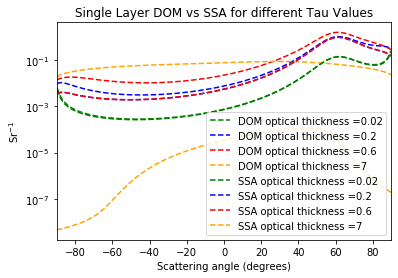

In [17]:
g=0.8
xl = g**np.arange(129)

ssa = 0.999
Ro = 0
mu0 = 0.5
#phi = 0

theta0 = 60 # degrees - incident angle
phi = 0 # relative azimuthal angle
theta = np.linspace(0,90, 32)
mu = np.cos(theta/180.0*np.pi)

Ndo = 32

tau1 = 0.02
tau2=0.2
tau3=0.6
tau4=7

[mu1, L1] = single_layer_DOM(mu0, phi, Ndo, tau1, ssa, xl, Ro)
L_transmitted11 = L1[3*Ndo:4*Ndo]
[mu1, L1] = single_layer_DOM(mu0, phi+np.pi, Ndo, tau1, ssa, xl, Ro)
L_transmitted21 = L1[3*Ndo:4*Ndo]
LL2_1 = np.concatenate((np.flip(L_transmitted21), L_transmitted11))

VZA1 = np.arccos(mu1)/np.pi*180
VZA1 = np.concatenate((-np.flip(VZA1), VZA1))

[mu2, L2] = single_layer_DOM(mu0, phi, Ndo, tau2, ssa, xl, Ro)
L_transmitted12 = L2[3*Ndo:4*Ndo]
[mu2, L2] = single_layer_DOM(mu0, phi+np.pi, Ndo, tau2, ssa, xl, Ro)
L_transmitted22 = L2[3*Ndo:4*Ndo]
LL2_2 = np.concatenate((np.flip(L_transmitted22), L_transmitted12))

VZA2 = np.arccos(mu2)/np.pi*180
VZA2 = np.concatenate((-np.flip(VZA2), VZA2))

[mu3, L3] = single_layer_DOM(mu0, phi, Ndo, tau3, ssa, xl, Ro)
L_transmitted13 = L3[3*Ndo:4*Ndo]
[mu3, L3] = single_layer_DOM(mu0, phi+np.pi, Ndo, tau3, ssa, xl, Ro)
L_transmitted23 = L3[3*Ndo:4*Ndo]
LL2_3 = np.concatenate((np.flip(L_transmitted23), L_transmitted13))

VZA3 = np.arccos(mu3)/np.pi*180
VZA3 = np.concatenate((-np.flip(VZA3), VZA3))

[mu4, L4] = single_layer_DOM(mu0, phi, Ndo, tau4, ssa, xl, Ro)
L_transmitted14 = L4[3*Ndo:4*Ndo]
[mu4, L4] = single_layer_DOM(mu0, phi+np.pi, Ndo, tau4, ssa, xl, Ro)
L_transmitted24 = L4[3*Ndo:4*Ndo]
LL2_4 = np.concatenate((np.flip(L_transmitted24), L_transmitted14))

VZA4 = np.arccos(mu4)/np.pi*180
VZA4 = np.concatenate((-np.flip(VZA4), VZA4))


pylab.semilogy(VZA1, LL2_1,'--', label = r'DOM optical thickness =' + str(tau1),color = 'g')
pylab.semilogy(VZA2, LL2_2, '--', label = r'DOM optical thickness =' + str(tau2),color = 'b')
pylab.semilogy(VZA3, LL2_3,'--', label = r'DOM optical thickness =' + str(tau3),color = 'r')
pylab.semilogy(VZA1, LL2_4,'--', label = r'DOM optical thickness =' + str(tau4),color = 'orange')



HG3_TAU1_SSA=np.zeros(len(mu))
HG3_TAU11_SSA=np.zeros(len(mu))
HG3_TAU2_SSA=np.zeros(len(mu))
HG3_TAU12_SSA=np.zeros(len(mu))
HG3_TAU3_SSA= np.zeros(len(mu))
HG3_TAU13_SSA=np.zeros(len(mu))
HG3_TAU4_SSA= np.zeros(len(mu))
HG3_TAU14_SSA=np.zeros(len(mu))

for i in range(len(mu)):
    HG3_TAU1_SSA[i] = single_scat_approx(tau1,mu0,mu1[i],xl,phi)
    HG3_TAU2_SSA[i] = single_scat_approx(tau2,mu0,mu2[i],xl,phi)
    HG3_TAU3_SSA[i] = single_scat_approx(tau3,mu0,mu3[i],xl,phi)
    HG3_TAU4_SSA[i] = single_scat_approx(tau4,mu0,mu4[i],xl,phi)
    HG3_TAU11_SSA[i] = single_scat_approx(tau1,mu0,mu1[i],xl,phi+np.pi)
    HG3_TAU12_SSA[i] = single_scat_approx(tau2,mu0,mu2[i],xl,phi+np.pi)
    HG3_TAU13_SSA[i] = single_scat_approx(tau3,mu0,mu3[i],xl,phi+np.pi)
    HG3_TAU14_SSA[i] = single_scat_approx(tau4,mu0,mu4[i],xl,phi+np.pi)


SSA1 = np.concatenate((np.flip(HG3_TAU11_SSA), HG3_TAU1_SSA))
SSA2 = np.concatenate((np.flip(HG3_TAU12_SSA), HG3_TAU2_SSA))
SSA3 = np.concatenate((np.flip(HG3_TAU13_SSA), HG3_TAU3_SSA))
SSA4 = np.concatenate((np.flip(HG3_TAU14_SSA), HG3_TAU4_SSA))

plt.semilogy(VZA1, SSA1, '--', label = r'SSA optical thickness =' + str(tau1),color = 'g')
plt.semilogy(VZA2, SSA2, '--', label = r'SSA optical thickness =' + str(tau2),color = 'b')
plt.semilogy(VZA3, SSA2, '--', label = r'SSA optical thickness =' + str(tau3),color = 'r')
plt.semilogy(VZA4, SSA4, '--', label = r'SSA optical thickness =' + str(tau4),color = 'orange')



plt.xlabel('Scattering angle (degrees)')
plt.ylabel(r'Sr$^{-1}$')
plt.legend()
plt.xlim([-90,90])
plt.title("Single Layer DOM vs SSA for different Tau Values")
plt.show()

    

#### Conclusion:

#### The Single Layer DOM is equal to Single Scattering approximation for a small tau value which we can see from the plot above. For tau values of 0.02 and 0.2, both the line plots coincide. However, when the tau value is more, for exampe, 0.6 and 7, the plots of DOM and SSA will not coincide,